# Second Analysis

Clusters and topics

Using Spacy and K-Means to analyze the tokens and try to group the contained sentences in each review.

Good tutorials and other texts

- Tutorial: Text Classification in Python Using spaCy
https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

## Importing all needed packages

Command to install **spaCy** package: ***pip install spacy***

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
import spacy
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
import seaborn as sns
import re
from pprint import pprint

## Loading the sentences of the CSV file.

In [2]:
nlp = spacy.load('pt_core_news_lg') # https://spacy.io/models/pt#pt_core_news_lg

In [3]:
df = pd.read_csv( 
    './datasets/sentences.csv',
    encoding = 'UTF8',
    sep = ';');
df.head()

,book_id,review_id,review_rating,sentence
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ..."
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176751 entries, 0 to 176750
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   book_id        176751 non-null  int64 
 1   review_id      176751 non-null  object
 2   review_rating  176751 non-null  int64 
 3   sentence       176750 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.4+ MB


In [5]:
df.iloc[0]['sentence']

'Sabe todos aqueles livros que ensinam você a criar uma agenda para controle de gastos contendo tudo que você gasta durante determinado período de tempo e que você nunca consegue terminar o tal método?'

In [6]:
doc = nlp( df.iloc[0]['sentence'] )
tokens = [token.text for token in doc]
print(tokens)

['Sabe', 'todos', 'aqueles', 'livros', 'que', 'ensinam', 'você', 'a', 'criar', 'uma', 'agenda', 'para', 'controle', 'de', 'gastos', 'contendo', 'tudo', 'que', 'você', 'gasta', 'durante', 'determinado', 'período', 'de', 'tempo', 'e', 'que', 'você', 'nunca', 'consegue', 'terminar', 'o', 'tal', 'método', '?']


In [7]:
tokens = [token.lemma_ for token in doc]
print(tokens)

['Sabe', 'todo', 'aquele', 'livro', 'que', 'ensinar', 'você', 'o', 'criar', 'umar', 'agendar', 'parir', 'controlo', 'de', 'gasto', 'conter', 'tudo', 'que', 'você', 'gasto', 'durante', 'determinar', 'período', 'de', 'tempo', 'e', 'que', 'você', 'nunca', 'conseguir', 'terminar', 'o', 'tal', 'método', '?']


In [8]:
tokens = [token.pos_ for token in doc]
print(tokens)

['VERB', 'DET', 'DET', 'NOUN', 'PRON', 'VERB', 'PRON', 'SCONJ', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN', 'VERB', 'PRON', 'PRON', 'PRON', 'VERB', 'ADP', 'VERB', 'NOUN', 'ADP', 'NOUN', 'CCONJ', 'SCONJ', 'PRON', 'ADV', 'VERB', 'VERB', 'DET', 'DET', 'NOUN', 'PUNCT']


## Analysis of the sentences sizes

In [9]:
df['sentence_size'] = [ len(str(sentence)) for sentence in df['sentence'] ]
df

,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...,200
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...,163
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ...",123
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...,55
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...,225
...,...,...,...,...,...
176746,8544106595,RQUIEDP9RU8GN,5,"Uma obra que toca nos seus maiores pesadelos,m...",302
176747,8544106595,R28THF88K7GE5S,5,"Leve,pesado,forte,suave,lindo,feio e todas as ...",59
176748,8544106595,R28THF88K7GE5S,5,"Lindo,lindo,lindo.",18
176749,8544106595,R28THF88K7GE5S,5,"Amei,comi,bebi cada palavra.",28


In [10]:
df['sentence_size'].describe()

count    176751.000000
mean         68.294205
std          62.576959
min           1.000000
25%          25.000000
50%          52.000000
75%          93.000000
max        2080.000000
Name: sentence_size, dtype: float64

## Analysis of top sentences

In [11]:
df['sentence'].value_counts()

                                                                                1116
Muito bom                                                                        584
Recomendo.                                                                       561
!                                                                                514
Muito bom!                                                                       459
                                                                                ... 
Muito bom, fácil a leitura e bem diferente dos filmes hehehehe                     1
O Senhor do anéis completo.                                                        1
Gostei tanto que comprei em seguida o box                                          1
História muito cativante e divertida de se ler.                                    1
A poesia de  Amanda  é visceral ,intensa e tão próxima de todas as mulheres.       1
Name: sentence, Length: 138605, dtype: int64

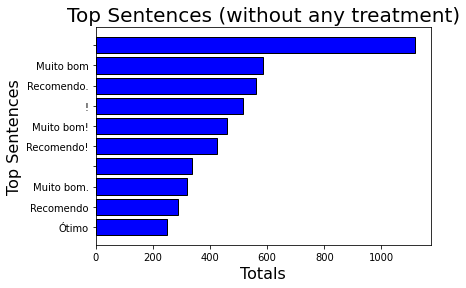

In [12]:
topSentencesLimit = 10
topSentences = df['sentence'].value_counts().index[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
pos = np.arange( topSentencesLimit )
sentenceTotals = df['sentence'].value_counts().values[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
 
plt.barh(
    pos,
    sentenceTotals,
    color='blue',
    edgecolor='black')
plt.yticks( pos, topSentences )
plt.xlabel( 'Totals', fontsize=16 )
plt.ylabel( 'Top Sentences', fontsize=16 )
plt.title( 'Top Sentences (without any treatment)', fontsize=20 )
plt.show()

### Function: cleanSentence()

In [13]:
tokensToClear = '\: \, \. \! \? \% \' \( \) \, \- \_ \“ \” \● \♥ \d \/ \$ \& \` \* \+ \❞ \° \– \…'
tokensToClear += ' 👏 💪 📸 😁 😍 😘 😚 🙂 🥰 🥺 ❤ 🏻 🏾 💃 💖 😉 😔 😲 ✨ 💗 💚 🔝 😊 😕 😻 🧐 🤧'
tokensToClear += ' um uma uns umas o a os as' 
tokensToClear += ' de do da des dos das em no na nos nas' 
tokensToClear += ' livro livros leitura' 
tokensToClear += ' muito eu mas mais pessoas' 
tokensToClear += ' como se tudo mesmo me sobre' 
tokensToClear += ' quem por todos e é seu eu minha meu' 
tokensToClear += ' ler esse essa esses essas cada isso' 
tokensToClear += ' eu tu ele nós vós eles' 
tokensToClear += ' que com ao tem pela muito para' 
tokensToClear += ' foi ter sua ser pra você super já são ou estou só até'
tokensToClear += ' bem bom'
tokensToClear += ' melhor ainda algum'

def cleanSentence( sentence ):
    
    sentence = str( sentence )
    sentence = sentence.lower()
    
    for token in tokensToClear.split():
        
        sentence = re.sub('^' + token + '\s', ' ', sentence) # at begining of the sentence
        sentence = re.sub('\s' + token + '$', ' ', sentence) # at ending of the sentence
        sentence = re.sub('\s' + token + '\s', ' ', sentence) # in the middle of the sentence
        
    sentence = re.sub('\s\s', ' ', sentence)
    sentence = re.sub('^\s', ' ', sentence)
    sentence = re.sub('\s$', ' ', sentence)
    sentence = sentence.strip()
        
    return sentence

In [14]:
sentence = "que o teste que estou fazendo que"
print( cleanSentence( sentence ) )

teste fazendo


In [15]:
df.head()

,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...,200
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...,163
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ...",123
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...,55
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...,225


In [16]:
%%time

dfTopSentences = df
dfTopSentences['sentence'] = df['sentence'].apply( lambda sentence: cleanSentence(sentence))
dfTopSentences.head()

CPU times: user 1min 29s, sys: 73.4 ms, total: 1min 29s
Wall time: 1min 29s


,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200
1,8595081530,RM0NBXMBSU4M3,4,"daqueles termina sentindo vida vai mudar, quan...",163
2,8595081530,RM0NBXMBSU4M3,4,"não vai encontrar setup milagroso, algum tipo ...",123
3,8595081530,RM0NBXMBSU4M3,4,basicamente este conta verdades dinheiro.,55
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma tão direta escrita acaba...,225


In [17]:
# %%time

# sentences = df['sentence'].tolist()
# cleanedSentences = [cleanSentence( sentence ) for sentence in sentences]
# dfTopSentences = df
# dfTopSentences['sentence'] = cleanedSentences
# dfTopSentences['sentence'].head()

CPU times: user 1min 20s, sys: 88.2 ms, total: 1min 20s
Wall time: 1min 20s


0    sabe aqueles ensinam criar agenda controle gas...
1    daqueles termina sentindo vida vai mudar, quan...
2    não vai encontrar setup milagroso, algum tipo ...
3            basicamente este conta verdades dinheiro.
4    mostra detalhes forma tão direta escrita acaba...
Name: sentence, dtype: object

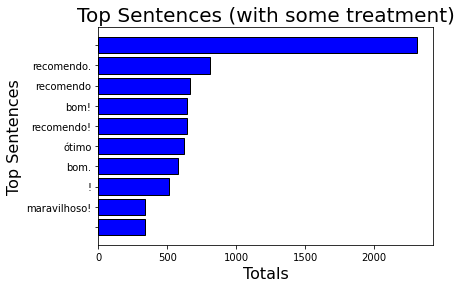

In [18]:
topSentencesLimit = 10
topSentences = dfTopSentences['sentence'].value_counts().index[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
pos = np.arange( topSentencesLimit )
sentenceTotals = dfTopSentences['sentence'].value_counts().values[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
 
plt.barh(
    pos,
    sentenceTotals,
    color='blue',
    edgecolor='black')
plt.yticks( pos, topSentences )
plt.xlabel( 'Totals', fontsize=16 )
plt.ylabel( 'Top Sentences', fontsize=16 )
plt.title( 'Top Sentences (with some treatment)', fontsize=20 )
plt.show()

### Repeated Sentences

In [19]:
total = len(dfTopSentences['sentence'])
values = dfTopSentences['sentence'].value_counts()[:total]
sentences = dfTopSentences['sentence'].value_counts()[:total].index

In [20]:
repeatedSentences = list()
for i in range(0, len(sentences)):
    # print( f'{sentence[i]} - {values[i]}' )
    if values[i] > 1:
        repeatedSentences.append( {
            'sentence': sentences[i],
            'value': values[i],
        } )

print( f'Total of results: { len(repeatedSentences) }' )
print( '--------------------------' )
print()

showTotal = 10
print( f'First {showTotal} results' )
print( '--------------------------' )
print()
for item in repeatedSentences[:showTotal]:
        
    print( f"{item['sentence']} - {item['value']}" )

print()
print( '===================================================' )
print()
    
print( f'Last {showTotal} results' )
print( '--------------------------' )
print()
for item in repeatedSentences[-showTotal:]:
        
    print( f"{item['sentence']} - {item['value']}" )

Total of results: 11683
--------------------------

First 10 results
--------------------------

 - 2315
recomendo. - 810
recomendo - 662
bom! - 642
recomendo! - 641
ótimo - 618
bom. - 576
! - 514
maravilhoso! - 341
️ - 339


Last 10 results
--------------------------

veio todo texto escrito ponta cabeça - 2
amo série... - 2
julia quinn excelente.. - 2
amei entrega rápida. - 2
aguardando coleção completa estante. - 2
lindo amei .empolgada comprar outros - 2
lendo quinto agora preferido. - 2
produto chegou perfeito estado, antes prazo previsto. - 2
dentre primeiros série. - 2
bridgestons clichê perfeito! - 2


### Unique Sentences

In [21]:
uniqueSentences = list()
for i in range(0, len(sentences)):
    
    if values[i] == 1:
        uniqueSentences.append( {
            'sentence': sentences[i],
            'value': values[i],
        } )

print( f'Total of results: { len(uniqueSentences) }' )
print( '--------------------------' )
print()

showTotal = 10
print( f'First {showTotal} results' )
print( '--------------------------' )
print()
for item in uniqueSentences[:showTotal]:
        
    print( f">>> {item['sentence']} - {item['value']}" )

print()
print( '===================================================' )
print()
    
print( f'Last {showTotal} results' )
print( '--------------------------' )
print()
for item in uniqueSentences[-showTotal:]:
        
    print( f">>> {item['sentence']} - {item['value']}" )

Total of results: 119959
--------------------------

First 10 results
--------------------------

>>> linda edição, sobrinha está maravilhada! - 1
>>> temos tate permissiva sem ambição aceita miles faz ela, quando esta vê amor ele, realmente, aceita pessoa deveria mínimo amor próprio aceita. - 1
>>> produto exatamente promete, chegou menos semana simplesmente maravilhoso!! - 1
>>> além perfeita edição, corte colorido, ilustrações magníficas diagramação boa. - 1
>>> acabamento perfeito lindo ver - 1
>>> tempo comprei, satisfeita agora - 1
>>> produto veio ótimo estado, antes prazo embalado. - 1
>>> comprei presente sobrinha 13 anos idade. - 1
>>> comprei marcador página entanto não veio marcador. - 1
>>> editado, ótimas ilustrações história contada, além bonito marcador páginas cordinha também serve este propósito. - 1


Last 10 results
--------------------------

>>> divertidíssimo, lê sorrindo. - 1
>>> ótimo livro, veio embalado - 1
>>> fitilho, gente. - 1
>>> design, diagramação, ilu

### A good question to future investigation:

We can relate these top sentences with users? Maybe the top sentences belongs to the same group of people...**

But we need to observe privacy before this...**

## Preparing the analysis dataframe

### Get only unique sentences to analyse

In [22]:
tempDf = df

In [23]:
tempDf['sentence'] = [cleanSentence(sentence) for sentence in tempDf['sentence']]

#### Length of tempDf

In [24]:
len(tempDf)

176751

In [25]:
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200
1,8595081530,RM0NBXMBSU4M3,4,"daqueles termina sentindo vida vai mudar, quan...",163
2,8595081530,RM0NBXMBSU4M3,4,"não vai encontrar setup milagroso, algum tipo ...",123
3,8595081530,RM0NBXMBSU4M3,4,basicamente este conta verdades dinheiro.,55
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma tão direta escrita acaba...,225


### Get the sentence words count

In [26]:
tempDf['sentence_words_count'] = tempDf.apply( lambda row: len( str(row['sentence']).split() ), axis = 1)
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200,18
1,8595081530,RM0NBXMBSU4M3,4,"daqueles termina sentindo vida vai mudar, quan...",163,14
2,8595081530,RM0NBXMBSU4M3,4,"não vai encontrar setup milagroso, algum tipo ...",123,14
3,8595081530,RM0NBXMBSU4M3,4,basicamente este conta verdades dinheiro.,55,5
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma tão direta escrita acaba...,225,23


### Sentences with fewer than the minimum number of words

In [27]:
tempDf[ tempDf[ 'sentence_words_count' ] < 5 ].head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
6,8595081530,RM0NBXMBSU4M3,4,ps.:,4,1
8,8595081530,RM0NBXMBSU4M3,4,recomendo muito!,16,2
14,8595081530,R3KC0ZLPQX85LT,5,outras moedas pode gastar.,36,4
16,8595081530,R3KC0ZLPQX85LT,5,"gastar necessidades, não desejos.",43,4
17,8595081530,R3KC0ZLPQX85LT,5,precisamos gastar menos ganhamos.2.,42,4


In [28]:
len( tempDf[ tempDf[ 'sentence_words_count' ] < 5 ] )

81377

### Filtering sentences with more than the minimum number of words

In [29]:
minWordCount = 5

tempDf['keep'] = tempDf.apply(lambda row: row['sentence_words_count'] > minWordCount, axis = 1)
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,keep
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200,18,True
1,8595081530,RM0NBXMBSU4M3,4,"daqueles termina sentindo vida vai mudar, quan...",163,14,True
2,8595081530,RM0NBXMBSU4M3,4,"não vai encontrar setup milagroso, algum tipo ...",123,14,True
3,8595081530,RM0NBXMBSU4M3,4,basicamente este conta verdades dinheiro.,55,5,False
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma tão direta escrita acaba...,225,23,True


In [30]:
tempDf.drop( 
    tempDf[ tempDf['keep'] == False ].index, 
    inplace = True )

In [31]:
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,keep
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200,18,True
1,8595081530,RM0NBXMBSU4M3,4,"daqueles termina sentindo vida vai mudar, quan...",163,14,True
2,8595081530,RM0NBXMBSU4M3,4,"não vai encontrar setup milagroso, algum tipo ...",123,14,True
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma tão direta escrita acaba...,225,23,True
5,8595081530,RM0NBXMBSU4M3,4,não ganha estrelas pois acredito arte capa pod...,163,16,True


#### Length of tempDf (after filter sentences with less than minimum number of words)

In [32]:
len( tempDf )

80727

#### Remove column *keep*

In [33]:
tempDf.drop(
    'keep', 
    axis = 1, 
    inplace = True)
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200,18
1,8595081530,RM0NBXMBSU4M3,4,"daqueles termina sentindo vida vai mudar, quan...",163,14
2,8595081530,RM0NBXMBSU4M3,4,"não vai encontrar setup milagroso, algum tipo ...",123,14
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma tão direta escrita acaba...,225,23
5,8595081530,RM0NBXMBSU4M3,4,não ganha estrelas pois acredito arte capa pod...,163,16


### Get unique sentences

In [34]:
uniqueSentencesList = [ item['sentence'] for item in uniqueSentences ]
# uniqueSentencesList

In [35]:
tempDf = tempDf[ tempDf[ 'sentence' ].isin(uniqueSentencesList) ]

#### Total of unique sentences

In [36]:
len(tempDf)

70055

In [37]:
tempDf

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200,18
1,8595081530,RM0NBXMBSU4M3,4,"daqueles termina sentindo vida vai mudar, quan...",163,14
2,8595081530,RM0NBXMBSU4M3,4,"não vai encontrar setup milagroso, algum tipo ...",123,14
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma tão direta escrita acaba...,225,23
5,8595081530,RM0NBXMBSU4M3,4,não ganha estrelas pois acredito arte capa pod...,163,16
...,...,...,...,...,...,...
176741,8544106595,RAJV7CI0NL7Q0,5,"amg vai amar ent obg escrito pq tanto eu, ela ...",134,16
176742,8544106595,R2QICSES0F3VIR,5,"adorei, veio todo embalado, sem nenhum arranhã...",60,8
176744,8544106595,R2QICSES0F3VIR,5,admito fiquei medo estragar durante percurso t...,144,13
176746,8544106595,RQUIEDP9RU8GN,5,"obra toca seus maiores pesadelos,mas apesar mo...",302,32


### Total of selected sentences to *analysisDf* dataframe

In [38]:
linesTotal = 1000

In [39]:
# analysisDf = tempDf.iloc[ :linesTotal ]
analysisDf = tempDf.sample( linesTotal )

In [40]:
analysisDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
147655,8551002341,R22L39K74UFU2O,3,não engatei história nem apeguei nenhum person...,61,7
169578,8565765695,R3182F7CM8RTSF,5,também vem ilustrações fofinhas primeira págin...,80,7
129770,8501105732,RE4MZC80NY4V9,5,"eu, certeza, leria!sobre leitura: fácil marcante.",65,6
79491,8575422391,R1K90XYT5VFBIU,3,"há boas dicas, contudo, certos momentos, coisa...",106,12
88589,8555341612,RAHLVWLKUILPR,5,"pelos personagens, pelos desenhos, detalhes, h...",74,7


In [41]:
analysisDf.tail()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
11260,8550802751,R1LQRSTEMBIVJE,5,autor faz várias analogias links vários assunt...,84,9
129410,8501105732,R17DF000OY2B5L,5,"enquanto finaliza faculdade enfermagem, ela di...",226,22
24346,8595083274,R3QPR9FW30MA1R,5,tipo book vc olhar sempre tirar alguma dúvida.,75,8
154614,8545202210,R1439UHFLDE7OC,5,"comprei sexta anoite,chegou sábado após almoço...",188,18
60263,8555340942,R1G032N62KQRDC,5,"terminei faz duas semanas quero reler, porque ...",78,9


In [42]:
analysisDf.shape

(1000, 6)

### Analysis of the sentences sizes

In [43]:
analysisDf['sentence_size'] = [ len(str(sentence)) for sentence in analysisDf['sentence'] ]
analysisDf

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
147655,8551002341,R22L39K74UFU2O,3,não engatei história nem apeguei nenhum person...,51,7
169578,8565765695,R3182F7CM8RTSF,5,também vem ilustrações fofinhas primeira págin...,55,7
129770,8501105732,RE4MZC80NY4V9,5,"eu, certeza, leria!sobre leitura: fácil marcante.",49,6
79491,8575422391,R1K90XYT5VFBIU,3,"há boas dicas, contudo, certos momentos, coisa...",93,12
88589,8555341612,RAHLVWLKUILPR,5,"pelos personagens, pelos desenhos, detalhes, h...",64,7
...,...,...,...,...,...,...
11260,8550802751,R1LQRSTEMBIVJE,5,autor faz várias analogias links vários assunt...,74,9
129410,8501105732,R17DF000OY2B5L,5,"enquanto finaliza faculdade enfermagem, ela di...",174,22
24346,8595083274,R3QPR9FW30MA1R,5,tipo book vc olhar sempre tirar alguma dúvida.,46,8
154614,8545202210,R1439UHFLDE7OC,5,"comprei sexta anoite,chegou sábado após almoço...",157,18


In [44]:
analysisDf['sentence_size'].describe()

count    1000.000000
mean       83.683000
std        44.409354
min        30.000000
25%        53.000000
50%        72.000000
75%       102.000000
max       402.000000
Name: sentence_size, dtype: float64

In [45]:
df['sentence_size'].describe()

count    80727.000000
mean       115.180621
std         64.568756
min         13.000000
25%         74.000000
50%         98.000000
75%        137.000000
max       2080.000000
Name: sentence_size, dtype: float64

### Disable warnings

In [46]:
import warnings
warnings.filterwarnings("ignore")

### Function: tokenizer()

In [47]:
def tokenizer( sentence ):
    
    doc = nlp( sentence )
    tokens = [token.lemma_ for token in doc]
    # tokens = [token.text for token in doc]
    
    return tokens

### max_df and min_df

In [48]:
max_df = .97
min_df = .03

# max_df = .98
# min_df = .02

# max_df = 1
# min_df = 0

## Building a Bag of Words (BoW) with the words of the sentences.

### BoW - Sparse Matrix - Token Frequency

In [49]:
%%time

vectorizer = CountVectorizer(
    tokenizer = tokenizer,
    ngram_range = (1,1),
    max_df = max_df,
    min_df = min_df)

dfBowTokenFrequency = pd.DataFrame(
    data = vectorizer.fit_transform( analysisDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowTokenFrequency.head(20)

CPU times: user 5.53 s, sys: 4.03 ms, total: 5.53 s
Wall time: 5.54 s


,!,(,),",",.,achar,algum,amar,antar,autor,...,sem,sentir,ser,também,te,ter,todo,tão,vidar,vir
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,2,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
print( f'Number of columns: {len( dfBowTokenFrequency.columns)}' )

Number of columns: 55


In [51]:
# for item in dfBowTokenFrequency.columns:
#     print(item)

#### WordCloud

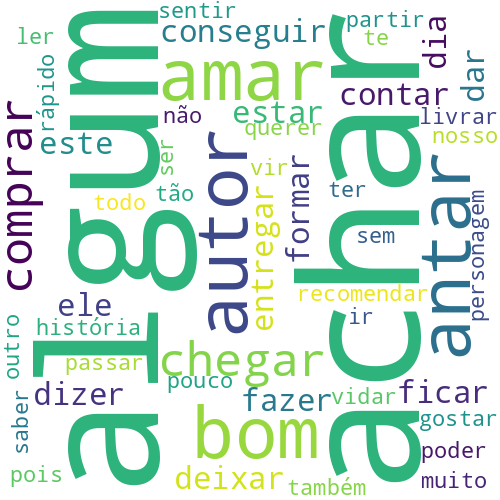

In [52]:
wordsBowTokenFrequency = ','.join( list(dfBowTokenFrequency.columns) )
wordcloud = WordCloud(
    background_color="white", 
    contour_width=3, 
    contour_color='steelblue',
    width=500,
    height=500)
wordcloud.generate( wordsBowTokenFrequency )
wordcloud.to_image()

### BoW - Sparse Matrix - Binary

In [53]:
%%time

vectorizer = CountVectorizer(
    tokenizer=tokenizer,
    ngram_range=(1,1),
    binary=True,
    max_df = max_df,
    min_df = min_df)

dfBowBinary = pd.DataFrame(
    data = vectorizer.fit_transform( analysisDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowBinary.head(20)

CPU times: user 5.08 s, sys: 43 µs, total: 5.08 s
Wall time: 5.08 s


,!,(,),",",.,achar,algum,amar,antar,autor,...,sem,sentir,ser,também,te,ter,todo,tão,vidar,vir
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
print( f'Number of columns: {len( dfBowBinary.columns)}' )

Number of columns: 55


#### WordCloud

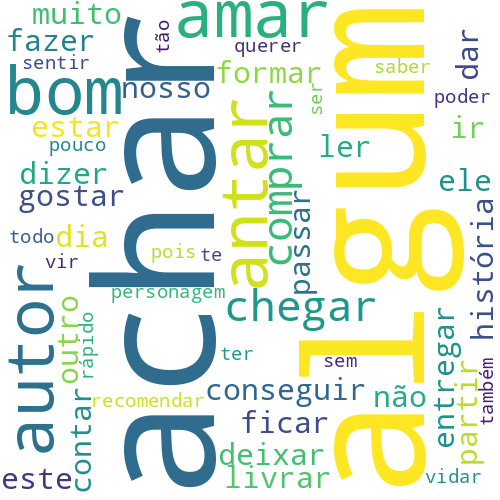

In [55]:
wordsBowBinary = ','.join( list(dfBowBinary.columns) )
wordcloud = WordCloud(
    background_color="white", 
    contour_width=3, 
    contour_color='steelblue',
    width=500,
    height=500)
wordcloud.generate( wordsBowBinary )
wordcloud.to_image()

### BoW - Sparse Matrix - TF-IDF

https://www.kaggle.com/code/k4puneet/countvectorizer-tfidf-tutorial/notebook

#### TfidfVectorizer

In [56]:
%%time

vectorizer = TfidfVectorizer( 
    analyzer = tokenizer,
    max_df = max_df,
    min_df = min_df)

dfBowTFIDF = pd.DataFrame(
    data = vectorizer.fit_transform( analysisDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowTFIDF.head(20)

CPU times: user 5.24 s, sys: 7.99 ms, total: 5.25 s
Wall time: 5.25 s


,!,(,),",",.,achar,algum,amar,antar,autor,...,sem,sentir,ser,também,te,ter,todo,tão,vidar,vir
0,0.000000,0.000000,0.000000,0.000000,0.211917,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.213509,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.734811,0.000000,0.000000,0.000000,0.0,0.000000,0.643790
2,0.000000,0.000000,0.000000,0.909055,0.416677,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.702003,0.214515,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.715330,0.163940,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.117310,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.305075,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.267167,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.254389,0.116602,0.000000,0.0,0.750265,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.208742,0.191359,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.658581,0.000000,0.000000,0.0,0.000000,0.000000
9,0.620746,0.000000,0.000000,0.252989,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [57]:
print( f'Number of columns: {len( dfBowTFIDF.columns )}' )

Number of columns: 55


#### WordCloud

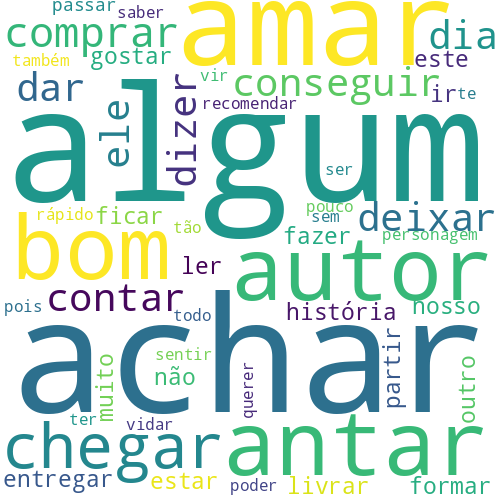

In [58]:
wordsBowTFIDF = ','.join( list(dfBowTFIDF.columns) )
wordcloud = WordCloud(
    background_color="white", 
    contour_width=3, 
    contour_color='steelblue',
    width=500,
    height=500)
wordcloud.generate( wordsBowTFIDF )
wordcloud.to_image()

### Total of clusters

In [59]:
clustersTotal = 5

### Function: classReport

In [60]:
def classReport( columnLabel, clustersTotal ):

    for i in range(0, clustersTotal):

        print( '===========================================================================' )
        print( f'Representation: {columnLabel} - class: {i}' )
        print( '===========================================================================' )
        print()

        dfClass = analysisDf[ analysisDf[ columnLabel ] == i ]

        display( dfClass.head(10) )
        print()

        print( f'Sentences by score from class {i}' )
        print( '====================================' )
        print( dfClass[ 'review_rating' ].value_counts().sort_index( ascending=False ) )
        print()

        print( f'Examples from class {i}' )
        print( '====================================' )
        print()

        if len( dfClass['sentence'] ) >= 5:
            sentencesClass = dfClass['sentence'].sample(5)
            for sentence in sentencesClass:
                print( sentence )
                print()
                print( '-----------------------------------' )
                print()
        else:
            for sentence in dfClass['sentence']:
                print( sentence )
                print()
                print( '-----------------------------------' )
                print()
                

        print( '###########################################################################' )
        print( '###########################################################################' )
        print( '###########################################################################' )
        print()

### K-Means - BoW - Sparse Matrix - Token Frequency

In [61]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowTokenFrequency )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [62]:
kmeans.labels_

array([4, 4, 1, 0, 0, 4, 3, 1, 1, 3, 3, 1, 4, 3, 4, 1, 4, 1, 4, 3, 1, 4,
       0, 3, 4, 2, 1, 1, 4, 4, 4, 1, 1, 3, 4, 4, 0, 2, 4, 1, 1, 0, 1, 4,
       4, 1, 4, 4, 1, 1, 1, 3, 1, 4, 3, 1, 0, 3, 4, 1, 3, 4, 3, 1, 1, 0,
       1, 4, 3, 4, 1, 0, 1, 1, 4, 1, 3, 3, 1, 4, 1, 4, 1, 4, 1, 0, 3, 3,
       4, 3, 1, 1, 1, 1, 1, 3, 4, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1,
       3, 1, 4, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 4, 3, 4, 4, 1, 1, 3, 1,
       1, 1, 4, 3, 1, 1, 1, 4, 4, 4, 4, 0, 1, 4, 1, 1, 1, 1, 4, 3, 4, 3,
       4, 4, 4, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 4, 1, 1, 3,
       1, 1, 3, 3, 4, 4, 1, 4, 3, 4, 1, 4, 3, 1, 1, 1, 1, 4, 3, 3, 4, 0,
       3, 0, 3, 3, 0, 4, 4, 3, 1, 0, 0, 0, 1, 4, 0, 2, 1, 3, 4, 1, 1, 3,
       4, 1, 4, 1, 1, 3, 1, 1, 4, 1, 1, 0, 3, 1, 1, 0, 1, 1, 1, 2, 3, 0,
       1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 4, 1, 4, 1, 3, 1, 1, 4,
       1, 1, 4, 4, 4, 2, 1, 1, 1, 1, 1, 1, 4, 4, 3, 1, 2, 1, 0, 4, 3, 1,
       0, 4, 0, 3, 0, 4, 1, 1, 3, 4, 3, 4, 3, 3, 4,

In [63]:
# kmeans.cluster_centers_

In [64]:
columnLabel = 'class__kmeans_bow_token_frequency'

In [65]:
analysisDf[columnLabel] = kmeans.labels_
analysisDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency
147655,8551002341,R22L39K74UFU2O,3,não engatei história nem apeguei nenhum person...,51,7,4
169578,8565765695,R3182F7CM8RTSF,5,também vem ilustrações fofinhas primeira págin...,55,7,4
129770,8501105732,RE4MZC80NY4V9,5,"eu, certeza, leria!sobre leitura: fácil marcante.",49,6,1
79491,8575422391,R1K90XYT5VFBIU,3,"há boas dicas, contudo, certos momentos, coisa...",93,12,0
88589,8555341612,RAHLVWLKUILPR,5,"pelos personagens, pelos desenhos, detalhes, h...",64,7,0


In [66]:
analysisDf[columnLabel].value_counts().sort_index()

0    125
1    430
2     29
3    176
4    240
Name: class__kmeans_bow_token_frequency, dtype: int64

#### PCA

In [67]:
# %%time

# pcaBowTokenFrequency = PCA( n_components=2 )
# principalComponentsBowTokenFrequency = pcaBowTokenFrequency.fit_transform( dfBowTokenFrequency )

In [68]:
# a = []
# b = []
# for item in principalComponentsBowTokenFrequency:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [69]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### MDS

In [70]:
# %%time

# mds = MDS(n_components=2)
# mds = mds.fit_transform( dfBowTokenFrequency )
# mds.shape

In [71]:
# a = []
# b = []
# for item in mds:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [72]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### TSNE

In [73]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowTokenFrequency )
tsne.shape

CPU times: user 21.8 s, sys: 147 ms, total: 21.9 s
Wall time: 6.59 s


(1000, 2)

In [74]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

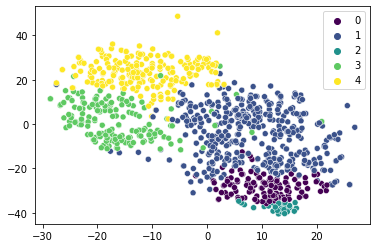

In [75]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [76]:
classReport( columnLabel, clustersTotal )

Representation: class__kmeans_bow_token_frequency - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency
79491,8575422391,R1K90XYT5VFBIU,3,"há boas dicas, contudo, certos momentos, coisa...",93,12,0
88589,8555341612,RAHLVWLKUILPR,5,"pelos personagens, pelos desenhos, detalhes, h...",64,7,0
150265,8580412382,RWNB51S0LU8Z9,5,conhece cinderela pode imaginar quanto vida fi...,108,15,0
41748,6555127279,R3V2CNZI1SRIQD,3,"produto veio qualidade nenhum erro, porém entr...",122,17,0
21333,8584391509,R3UM40IBY9MZSL,5,"achei seria chato, dei chance e, nossa, surpre...",51,8,0
21759,8595083274,R36KK654OKJRO3,4,"segunda parte (investir melhor), autor mostra ...",220,28,0
135588,8501304468,RJUJVFBWM772R,5,"sei parecem críticas pesadas, referentes apena...",114,16,0
161806,8532649963,R319W7SLXJT1DE,5,"vemos nesse caminhamos, melhor, corremos passo...",177,22,0
80177,8575422391,RYR9BZFXAL00D,5,"não contém apenas segredos, próprio guia, séri...",122,20,0
36131,8547000240,R1OAYOJUT6HQYR,3,"relação entrega, dentro prazo, porém, correio ...",96,13,0



Sentences by score from class 0
5    85
4    14
3    14
2     5
1     7
Name: review_rating, dtype: int64

Examples from class 0

li abordam conceitos espirituais diferentes tenho, eckhart tolle, dele têm algo contribuir, profundidade.

-----------------------------------

chorei alguns poemas, história muitos momentos partir coração acaba tendo reviravolta interna, interna, personagem percebe valor consegue finalmente obter algo há lhe negado “amor próprio”.

-----------------------------------

produto veio qualidade nenhum erro, porém entrega atrasou três semanas, deixou pouco decepcionada, nada demais também não.

-----------------------------------

autora não fez romance comum lgbt+, q existem bi, gay lésbica, ela incluiu outros gêneros tbm.

-----------------------------------

então, respeite opinião pessoa está passando isso, porque ninguém, exatamente ninguém sabe ela está passando.

-----------------------------------

#######################################################

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency
129770,8501105732,RE4MZC80NY4V9,5,"eu, certeza, leria!sobre leitura: fácil marcante.",49,6,1
44062,8501117684,R2FZJD024UYG0T,3,"amo colen hoover, amo escrita dela, forma ela ...",77,11,1
591,8595081530,R3IOJ7VQ6YUS5F,5,espera te ensine ganhar dinheiro vai decepcion...,72,11,1
79320,8575422391,R3GYN01X1ZK7QH,5,ajudou eliminar crenças limitantes tinha vida ...,121,15,1
166520,8535932879,RZ6FHV0048IS2,5,"pudesse tido chance lido algo parecido antes, ...",65,10,1
77375,6555650001,ROJ2ISP82M9VH,4,baile vê insatisfação jovem apresentada homens...,130,17,1
51229,8595084742,R2AWH6GSRU1PX2,5,"aqui, indiscutível temos algo visivelmente fei...",70,10,1
148933,8551002341,R35XWA4X7K6Z69,5,"recomendo fazerem isso, vocês vão apaixonar!o ...",122,17,1
131908,8501105732,R10HUREH6EBMCM,5,"achei era playboy mocinha ingênua, porém longe...",53,8,1
126137,8584391401,R2UC1UNX82LEJE,4,"poster filme (sem aquele óculos espelhado), de...",68,9,1



Sentences by score from class 1
5    306
4     64
3     31
2     18
1     11
Name: review_rating, dtype: int64

Examples from class 1

não não identificar alguma caracteristica deles, algum medo, defeito virtude.

-----------------------------------

profundo realista, logoterapia algo viktor frankl criou salvar almas clementes, acabou salvando.

-----------------------------------

poster lindo também, provavelmente vou fazer quadro ele.

-----------------------------------

indico livro, principalmente aqueles não sabem linguagem amor cônjuge.

-----------------------------------

confesso não meus favoritos, não dizendo ruim.

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__kmeans_bow_token_frequency - class: 2



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency
158241,6558380544,R1C8N4L0Z8NBOQ,5,nora acaba biblioteca após decidir não quer co...,255,37,2
30382,6580309318,R3SYFZEQMM12T1,5,detalhe notável autor trabalha grande número p...,224,28,2
21682,8595083274,R381JA2ZRAK96H,5,"geral agradável, início pouco densa, diferenci...",194,22,2
162688,8594541473,R2H7DCI9P59LSN,3,"informações encontra livro, pode qualquer site...",130,17,2
87951,8555341612,R2ZLKTKIEWERTE,3,"sei nem responsabilidade empresa, estava solto...",315,43,2
114642,8508196555,R2HLLDRPRBAHFO,4,invenção homemparabéns falecido jornalista aud...,153,18,2
127777,8584391401,R1IRU5RMZAV24A,4,"quando junta daisy, explosão sucesso garantido...",118,14,2
73300,8555340896,R29OU7LSKOYJAT,5,"amei livro, autora maravilhosa, personagens, e...",74,9,2
22009,8595083274,RXT27HAT0DQTE,5,"dividido partes: gastar bem, investir ganhar m...",189,23,2
120077,8532530788,R2SGRAOVGJQQD4,5,"sempre gostei filmes harry potter, ai li livro...",402,59,2



Sentences by score from class 2
5    20
4     7
3     2
Name: review_rating, dtype: int64

Examples from class 2

informações encontra livro, pode qualquer site meia boca, exemplo, elizabeth bathory, autora não passou confiança estava contando,

-----------------------------------

melhores li, não perca tempo ler, lei baseada exemplos históricos onde lei transgredida aplicada respectivamente, seguido interpretação, chaves poder, q imagem autoridade, citação grande nome aconselhando seguir lei si.

-----------------------------------

comprei sexta anoite,chegou sábado após almoço, relação entrega nunca decepciona, produto veio plastificado embalado,entrega rápido certinha, veio anunciado.

-----------------------------------

personagens erram, pecam, magoam, ofendem, também guerreiros, lutam seus sonhos, acreditam seus ideais.

-----------------------------------

vai te consumir forma, nao irá conseguir parar (sim, li vários comentários falando isso, pensei seria impossível, verdad

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency
50525,8539004119,R2L1PWC00PUYJ0,5,"simples cativante, não deixa apresentar concei...",58,7,3
9970,8550802751,RK78FD0DIOJYX,5,"além lições interessantes, forma escrever bela!",47,6,3
141531,8576849941,R136S6BZLKOS3,5,"chegou outro dia após compra, rápido!em relaçã...",63,9,3
139776,8565765482,R2MIM4E2FKEPIT,5,incríveis vi acho todo terra q,30,6,3
67481,8535909559,R1BV2V2QV78S40,4,ótima sátira qual homens animais confundem...,45,6,3
132499,8501105732,R2S4GL756FAPQH,5,nunca li tão envolvente quanto esse!ele realis...,55,8,3
68582,8535909559,R138Y0NT5FXGH0,5,isso: parece-me fundamental formação humana in...,65,7,3
39933,8542218752,R242FPSBU74UZX,5,"p brunet escreveu, vale pena reler",34,6,3
160318,8501117846,R3D5GZXPJ46RA0,5,gosto desta autora neste consegue perceber ama...,65,8,3
129412,8501105732,R17DF000OY2B5L,5,assim chega apartamento descobre duas coisas:,45,6,3



Sentences by score from class 3
5    146
4     17
3      7
2      3
1      3
Name: review_rating, dtype: int64

Examples from class 3

será ambos estão preparados desafios vida dois

-----------------------------------

chegou antes prazo, satisfeito vendedor esta parabéns!

-----------------------------------

chegou outro dia após compra, rápido!em relação gostei muito!!!

-----------------------------------

recomento casais namorado, noivos casados leiam surpreendam

-----------------------------------

quanto à história, não há falar, maravilhosa!!

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__kmeans_bow_token_frequency - class: 4



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency
147655,8551002341,R22L39K74UFU2O,3,não engatei história nem apeguei nenhum person...,51,7,4
169578,8565765695,R3182F7CM8RTSF,5,também vem ilustrações fofinhas primeira págin...,55,7,4
32288,6580309318,RF34AXYZUO1PI,5,trama vai sendo desenrolada aos poucos vamos v...,104,14,4
12960,8568014003,R27Q6AL71KPBXL,5,trata-se alerta aos hábitos desenvolvemos long...,129,18,4
47842,8539004119,R3MBLNHRLZA7Q,4,gostei saber poderemos substituir nossos hábit...,69,8,4
12015,8568014003,R20PDYUR0W8WH3,3,fui influenciado devido indicações vários guru...,67,8,4
22155,8595083274,R1ZK9J69YSBEHC,5,três pilares apresentados pelo primo simples e...,113,14,4
84939,8543102146,R1Y7JMEDA7D091,5,aprendizado neste vai começo fim achei indispe...,61,8,4
111856,8542209826,R2Q82D15W72W84,4,então tô escrevendo agora conseguir realmente ...,71,10,4
8947,8550802751,RUTVRY8PSZ69Q,4,doze regras vida espécie autoajuda diferente.,45,6,4



Sentences by score from class 4
5    192
4     23
3     11
2      4
1     10
Name: review_rating, dtype: int64

Examples from class 4

excelente começar aprender mercado financeiro investimentos gerais.

-----------------------------------

kkkkk todas suas imperfeições ta pertinho deles.

-----------------------------------

jordan peterson traz profundas reflexões vida humano.

-----------------------------------

evelyn hugo mulher repugnante tempo inspiradora.

-----------------------------------

daquele tipo te instiga faz não querer largar terminar entender acontece.

-----------------------------------

###########################################################################
###########################################################################
###########################################################################



### K-Means - BoW - Sparse Matrix - Binary

In [77]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowBinary )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [78]:
kmeans.labels_

array([1, 1, 2, 2, 2, 1, 0, 2, 0, 3, 3, 2, 1, 3, 1, 2, 1, 2, 1, 3, 2, 1,
       3, 3, 1, 0, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 4, 0, 1, 2, 2, 2, 2, 1,
       1, 2, 1, 1, 2, 0, 3, 3, 2, 1, 3, 0, 2, 3, 1, 2, 3, 1, 3, 2, 2, 2,
       2, 1, 3, 1, 0, 0, 2, 2, 1, 2, 3, 3, 2, 1, 2, 4, 2, 1, 0, 3, 3, 3,
       1, 3, 2, 2, 2, 4, 2, 3, 1, 3, 2, 2, 2, 0, 2, 2, 2, 0, 0, 3, 2, 2,
       4, 2, 1, 2, 2, 2, 1, 1, 2, 2, 3, 2, 2, 0, 1, 3, 1, 1, 2, 2, 4, 2,
       2, 2, 1, 3, 2, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 0, 1, 3, 1, 3,
       1, 1, 1, 0, 2, 2, 3, 3, 2, 3, 0, 0, 0, 0, 2, 0, 3, 0, 1, 2, 2, 3,
       2, 2, 0, 3, 1, 1, 2, 1, 3, 1, 4, 1, 3, 2, 2, 2, 0, 1, 4, 3, 1, 2,
       3, 2, 3, 3, 0, 1, 1, 3, 3, 2, 0, 2, 0, 1, 3, 2, 2, 3, 1, 3, 2, 3,
       1, 2, 1, 2, 3, 3, 3, 2, 1, 0, 2, 0, 3, 2, 0, 3, 2, 2, 2, 0, 3, 3,
       4, 2, 3, 2, 2, 2, 3, 0, 0, 0, 0, 0, 2, 3, 1, 0, 1, 0, 3, 2, 2, 1,
       0, 2, 1, 1, 1, 0, 2, 0, 2, 3, 2, 2, 1, 1, 4, 3, 2, 2, 4, 1, 0, 0,
       3, 1, 0, 3, 2, 1, 2, 2, 3, 1, 3, 1, 3, 3, 1,

In [79]:
# kmeans.cluster_centers_

In [80]:
columnLabel = 'class__kmeans_bow_binary'

In [81]:
analysisDf[columnLabel] = kmeans.labels_
analysisDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary
147655,8551002341,R22L39K74UFU2O,3,não engatei história nem apeguei nenhum person...,51,7,4,1
169578,8565765695,R3182F7CM8RTSF,5,também vem ilustrações fofinhas primeira págin...,55,7,4,1
129770,8501105732,RE4MZC80NY4V9,5,"eu, certeza, leria!sobre leitura: fácil marcante.",49,6,1,2
79491,8575422391,R1K90XYT5VFBIU,3,"há boas dicas, contudo, certos momentos, coisa...",93,12,0,2
88589,8555341612,RAHLVWLKUILPR,5,"pelos personagens, pelos desenhos, detalhes, h...",64,7,0,2


In [82]:
analysisDf[columnLabel].value_counts().sort_index()

0    130
1    235
2    385
3    206
4     44
Name: class__kmeans_bow_binary, dtype: int64

#### PCA

In [83]:
# %%time

# pcaBowBinary = PCA( n_components=2 )
# principalComponentsBowBinary = pcaBowBinary.fit_transform( dfBowBinary )

In [84]:
# a = []
# b = []
# for item in principalComponentsBowBinary:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [85]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### MDS

In [86]:
# %%time

# mds = MDS(n_components=2)
# mds = mds.fit_transform( dfBowBinary )
# mds.shape

In [87]:
# a = []
# b = []
# for item in mds:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [88]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### TSNE

In [89]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowBinary )
tsne.shape

CPU times: user 17.7 s, sys: 90.9 ms, total: 17.8 s
Wall time: 5.13 s


(1000, 2)

In [90]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

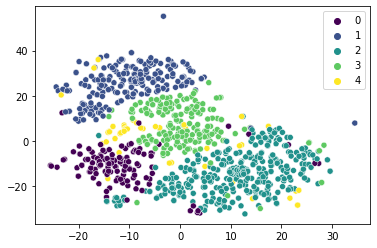

In [91]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [92]:
classReport( columnLabel, clustersTotal )

Representation: class__kmeans_bow_binary - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary
50525,8539004119,R2L1PWC00PUYJ0,5,"simples cativante, não deixa apresentar concei...",58,7,3,0
591,8595081530,R3IOJ7VQ6YUS5F,5,espera te ensine ganhar dinheiro vai decepcion...,72,11,1,0
158241,6558380544,R1C8N4L0Z8NBOQ,5,nora acaba biblioteca após decidir não quer co...,255,37,2,0
30382,6580309318,R3SYFZEQMM12T1,5,detalhe notável autor trabalha grande número p...,224,28,2,0
166135,8535932879,R2KQ8NOENL7828,2,"não trata pequeno manual, sim minúsculo.",40,6,1,0
45136,8501117684,R37EBHMG9ZUY1E,5,"alguma dúvida relação livro, não tenha.",39,6,1,0
67228,8535909559,R2YU9RZ0HHHT02,5,"excelente leitura, recomendo não apenas alegor...",74,9,1,0
161806,8532649963,R319W7SLXJT1DE,5,"vemos nesse caminhamos, melhor, corremos passo...",177,22,0,0
16832,8584391509,R20Q2T5HN44W7Y,5,"longe perfeita, evelyn teve muitas escolhas di...",142,19,1,0
36131,8547000240,R1OAYOJUT6HQYR,3,"relação entrega, dentro prazo, porém, correio ...",96,13,0,0



Sentences by score from class 0
5    81
4    18
3    15
2    10
1     6
Name: review_rating, dtype: int64

Examples from class 0

tive impressão ela poderia resolvido problematização td mt melhor, calma pros personagens resolverem, não página.

-----------------------------------

descreverei seguir principais tópicos justificados pelo autor torna humanidade limitada fazer livrar-se disso, pois durante esta parte descritas características negativas levam aos fracassos outros problemas forma lidar não cair “armadilhas diabo”.

-----------------------------------

não apenas historia romance, vai alem disso, história sente real, casal incrível, poucos casais enfrentariam passaram, história perfeita.

-----------------------------------

autora não fez romance comum lgbt+, q existem bi, gay lésbica, ela incluiu outros gêneros tbm.

-----------------------------------

pouco menor imaginava, culpa não checado tamanho, rs

-----------------------------------

##############################

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary
147655,8551002341,R22L39K74UFU2O,3,não engatei história nem apeguei nenhum person...,51,7,4,1
169578,8565765695,R3182F7CM8RTSF,5,também vem ilustrações fofinhas primeira págin...,55,7,4,1
32288,6580309318,RF34AXYZUO1PI,5,trama vai sendo desenrolada aos poucos vamos v...,104,14,4,1
12960,8568014003,R27Q6AL71KPBXL,5,trata-se alerta aos hábitos desenvolvemos long...,129,18,4,1
47842,8539004119,R3MBLNHRLZA7Q,4,gostei saber poderemos substituir nossos hábit...,69,8,4,1
12015,8568014003,R20PDYUR0W8WH3,3,fui influenciado devido indicações vários guru...,67,8,4,1
22155,8595083274,R1ZK9J69YSBEHC,5,três pilares apresentados pelo primo simples e...,113,14,4,1
84939,8543102146,R1Y7JMEDA7D091,5,aprendizado neste vai começo fim achei indispe...,61,8,4,1
111856,8542209826,R2Q82D15W72W84,4,então tô escrevendo agora conseguir realmente ...,71,10,4,1
8947,8550802751,RUTVRY8PSZ69Q,4,doze regras vida espécie autoajuda diferente.,45,6,4,1



Sentences by score from class 1
5    189
4     22
3     10
2      4
1     10
Name: review_rating, dtype: int64

Examples from class 1

revoluciona maneira qual pensa manhã termos qualidade vida produtividade.

-----------------------------------

narrativa dela não cansativa personagens maravilhosos.

-----------------------------------

história linda autora sabe descrever perfeitamente fatos costumes época monta personalidade personagens.

-----------------------------------

vi vou chorar horrores lendo maravilhoso.

-----------------------------------

aquele tipo te ensina marca fundo alma tão perfeito.

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__kmeans_bow_binary - class: 2



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary
129770,8501105732,RE4MZC80NY4V9,5,"eu, certeza, leria!sobre leitura: fácil marcante.",49,6,1,2
79491,8575422391,R1K90XYT5VFBIU,3,"há boas dicas, contudo, certos momentos, coisa...",93,12,0,2
88589,8555341612,RAHLVWLKUILPR,5,"pelos personagens, pelos desenhos, detalhes, h...",64,7,0,2
44062,8501117684,R2FZJD024UYG0T,3,"amo colen hoover, amo escrita dela, forma ela ...",77,11,1,2
79320,8575422391,R3GYN01X1ZK7QH,5,ajudou eliminar crenças limitantes tinha vida ...,121,15,1,2
166520,8535932879,RZ6FHV0048IS2,5,"pudesse tido chance lido algo parecido antes, ...",65,10,1,2
77375,6555650001,ROJ2ISP82M9VH,4,baile vê insatisfação jovem apresentada homens...,130,17,1,2
51229,8595084742,R2AWH6GSRU1PX2,5,"aqui, indiscutível temos algo visivelmente fei...",70,10,1,2
148933,8551002341,R35XWA4X7K6Z69,5,"recomendo fazerem isso, vocês vão apaixonar!o ...",122,17,1,2
131908,8501105732,R10HUREH6EBMCM,5,"achei era playboy mocinha ingênua, porém longe...",53,8,1,2



Sentences by score from class 2
5    274
4     58
3     30
2     13
1     10
Name: review_rating, dtype: int64

Examples from class 2

veio estado, apenas tiveram algumas folhas (5 4) meio estavam apenas pouquinho amassadas, nada mais.

-----------------------------------

bom, li pelo prime, achei objetivo, sem rodeios.

-----------------------------------

pouco à pouco, porcos vão adquirindo hábitos humanos: dormem camas, usam roupas, bebem álcool andam duas pernas.

-----------------------------------

além disso, achei dessa edição fluida, sem travar palavras.

-----------------------------------

bom, facil dicas párticas desenvolvimento pessoal.

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__kmeans_bow_binary - class: 3



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary
9970,8550802751,RK78FD0DIOJYX,5,"além lições interessantes, forma escrever bela!",47,6,3,3
141531,8576849941,R136S6BZLKOS3,5,"chegou outro dia após compra, rápido!em relaçã...",63,9,3,3
139776,8565765482,R2MIM4E2FKEPIT,5,incríveis vi acho todo terra q,30,6,3,3
67481,8535909559,R1BV2V2QV78S40,4,ótima sátira qual homens animais confundem...,45,6,3,3
150265,8580412382,RWNB51S0LU8Z9,5,conhece cinderela pode imaginar quanto vida fi...,108,15,0,3
132499,8501105732,R2S4GL756FAPQH,5,nunca li tão envolvente quanto esse!ele realis...,55,8,3,3
68582,8535909559,R138Y0NT5FXGH0,5,isso: parece-me fundamental formação humana in...,65,7,3,3
47872,8539004119,R3CQ673H3NTHJ4,5,"mostra mudança habito pode afetar vida,seja po...",166,18,1,3
39933,8542218752,R242FPSBU74UZX,5,"p brunet escreveu, vale pena reler",34,6,3,3
160318,8501117846,R3D5GZXPJ46RA0,5,gosto desta autora neste consegue perceber ama...,65,8,3,3



Sentences by score from class 3
5    171
4     23
3      6
2      3
1      3
Name: review_rating, dtype: int64

Examples from class 3

excelente conteúdo nosso fortalecimento interior motivacional

-----------------------------------

mal colada, soltando folha trás capa...

-----------------------------------

diz ditado não podemos elogiar senão estraga!

-----------------------------------

aborda assunto diversas histórias interessantes hábito funciona influencia comportamento, tanto organizacional, pessoal, cultural, etc...

-----------------------------------

amei toda narrativa vida dela destacando erros acertos.....

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__kmeans_bow_binary - class: 4



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary
41748,6555127279,R3V2CNZI1SRIQD,3,"produto veio qualidade nenhum erro, porém entr...",122,17,0,4
139936,8535933921,R14MAQJ95X3XR9,3,entrega rápida acabamento nova edição bom.,42,6,4,4
173509,8565765695,R1CPDNL2QTHK7I,5,"perfeito, amei coml veio todo embrulhadinho, e...",60,8,1,4
55201,8595084742,RC2E1K2UEXVGW,5,"mt bom, qualidade impecável chegou rápido tbm",45,7,3,4
130896,8501105732,RWCLCA02R8TU7,5,entrega rápida colleen eh maravilhosa não não ...,50,8,3,4
123338,8551006754,R3A2IVN8MSY7XT,5,"sem plavaras, neil gaiman entrega conto fadas ...",62,9,1,4
136439,8501304468,RD0MT4ZA7JO3G,5,box ótima qualidade entrega rápida sempre,41,6,3,4
54313,8595084742,R18TNELEC4OF98,5,"tempo entrega antes previsto, produto ótimo es...",72,10,1,4
118814,8532530788,R30NNDHY93K63Q,5,"produto ótimo estado entrega rápida, ótima",42,6,3,4
163421,8594541473,RLQUEXF3XNJV0,5,"achei lindo demais, entrega rápida, chegou ant...",91,15,0,4



Sentences by score from class 4
5    34
4     4
3     4
1     2
Name: review_rating, dtype: int64

Examples from class 4

produto ótimo estado entrega rápida, ótima

-----------------------------------

chegou antes prazo qualidade, entregador carlos atencioso responsável ligou avisando entrega, deixo aqui agradecimento.

-----------------------------------

gosto transportadora total express, sempre chega rápido casa (sou prime) atualiza direito roteiro entrega, contrário demais.

-----------------------------------

entrega rápida colleen eh maravilhosa não não amar

-----------------------------------

entrega amazon perfeita, chegou embalado ótimo estado, gostei muito.

-----------------------------------

###########################################################################
###########################################################################
###########################################################################



### K-Means - BoW - Sparse Matrix - TF-IDF

In [93]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowTFIDF )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [94]:
kmeans.labels_

array([1, 4, 0, 0, 0, 3, 1, 4, 1, 2, 2, 4, 4, 4, 4, 4, 3, 0, 4, 4, 4, 4,
       2, 2, 4, 1, 4, 3, 4, 4, 4, 4, 4, 2, 4, 4, 1, 0, 1, 4, 4, 0, 4, 4,
       4, 4, 4, 4, 4, 1, 2, 0, 4, 4, 2, 1, 0, 4, 4, 0, 2, 3, 2, 0, 0, 0,
       4, 4, 4, 4, 1, 0, 0, 0, 4, 4, 3, 2, 4, 4, 4, 4, 4, 4, 1, 2, 3, 2,
       4, 4, 4, 0, 0, 4, 4, 4, 4, 2, 4, 3, 0, 1, 4, 4, 0, 4, 1, 1, 4, 4,
       4, 4, 3, 0, 3, 4, 1, 4, 3, 3, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 1, 0,
       0, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 0, 3, 4, 4, 4, 0, 1, 4, 3, 4, 4,
       4, 4, 4, 1, 0, 4, 2, 2, 4, 4, 1, 3, 1, 1, 3, 0, 4, 4, 4, 4, 0, 0,
       0, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 0, 3, 4, 1, 3, 4, 4, 4, 0,
       4, 4, 4, 4, 1, 4, 1, 4, 2, 3, 1, 0, 1, 4, 3, 0, 4, 0, 4, 0, 4, 2,
       4, 4, 4, 4, 0, 1, 2, 4, 4, 1, 4, 3, 2, 4, 3, 2, 0, 4, 4, 0, 4, 0,
       4, 3, 4, 0, 4, 4, 0, 1, 0, 1, 1, 1, 0, 1, 4, 1, 4, 1, 2, 2, 3, 4,
       1, 4, 4, 4, 4, 1, 4, 3, 4, 2, 4, 0, 4, 4, 4, 4, 0, 0, 1, 1, 1, 3,
       2, 4, 1, 4, 0, 1, 0, 4, 4, 3, 0, 4, 2, 4, 4,

In [95]:
# kmeans.cluster_centers_

In [96]:
columnLabel = 'class__kmeans_bow_tfidf'

In [97]:
analysisDf[columnLabel] = kmeans.labels_
analysisDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary,class__kmeans_bow_tfidf
147655,8551002341,R22L39K74UFU2O,3,não engatei história nem apeguei nenhum person...,51,7,4,1,1
169578,8565765695,R3182F7CM8RTSF,5,também vem ilustrações fofinhas primeira págin...,55,7,4,1,4
129770,8501105732,RE4MZC80NY4V9,5,"eu, certeza, leria!sobre leitura: fácil marcante.",49,6,1,2,0
79491,8575422391,R1K90XYT5VFBIU,3,"há boas dicas, contudo, certos momentos, coisa...",93,12,0,2,0
88589,8555341612,RAHLVWLKUILPR,5,"pelos personagens, pelos desenhos, detalhes, h...",64,7,0,2,0


In [98]:
analysisDf[columnLabel].value_counts().sort_index()

0    231
1    139
2     83
3     78
4    469
Name: class__kmeans_bow_tfidf, dtype: int64

#### PCA

In [99]:
# %%time

# pca = PCA( n_components=2 )
# principalComponents = pca.fit_transform( dfBowTFIDF )

In [100]:
# a = []
# b = []
# for item in principalComponents:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [101]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### MDS

In [102]:
# %%time

# mds = MDS(n_components=2)
# mds = mds.fit_transform( dfBowTFIDF )
# mds.shape

In [103]:
# a = []
# b = []
# for item in mds:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [104]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### TSNE

In [105]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowTFIDF )
tsne.shape

CPU times: user 17 s, sys: 110 ms, total: 17.1 s
Wall time: 5.01 s


(1000, 2)

In [106]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

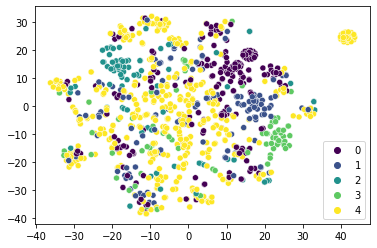

In [107]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [108]:
classReport( columnLabel, clustersTotal )

Representation: class__kmeans_bow_tfidf - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary,class__kmeans_bow_tfidf
129770,8501105732,RE4MZC80NY4V9,5,"eu, certeza, leria!sobre leitura: fácil marcante.",49,6,1,2,0
79491,8575422391,R1K90XYT5VFBIU,3,"há boas dicas, contudo, certos momentos, coisa...",93,12,0,2,0
88589,8555341612,RAHLVWLKUILPR,5,"pelos personagens, pelos desenhos, detalhes, h...",64,7,0,2,0
77375,6555650001,ROJ2ISP82M9VH,4,baile vê insatisfação jovem apresentada homens...,130,17,1,2,0
30382,6580309318,R3SYFZEQMM12T1,5,detalhe notável autor trabalha grande número p...,224,28,2,0,0
21333,8584391509,R3UM40IBY9MZSL,5,"achei seria chato, dei chance e, nossa, surpre...",51,8,0,2,0
39933,8542218752,R242FPSBU74UZX,5,"p brunet escreveu, vale pena reler",34,6,3,3,0
21759,8595083274,R36KK654OKJRO3,4,"segunda parte (investir melhor), autor mostra ...",220,28,0,2,0
131551,8501105732,R2B4HHH8ZTO48W,5,"então quando li segunda vez, entendi miles, en...",77,12,1,2,0
142797,8576849941,R2LYDGU7U6D2NA,3,"extremamente prolixo, fala varias bobagens nit...",75,8,1,2,0



Sentences by score from class 0
5    165
4     35
3     19
2      6
1      6
Name: review_rating, dtype: int64

Examples from class 0

comprei num impulso, causa desconto, arrependi pouco começo, pensando ia tediante, banda rock anos 70 nunca interessei assunto.não podia estar errada.

-----------------------------------

isso, romance estilo conto fadas, direito príncipe.

-----------------------------------

empacotado, apesar pequeno amassado pontas nada faça devolver, óbvio.

-----------------------------------

edição feita, belas ilustrações vinicius rossignol felipe, notas explicativas introdução jornalista descobriu editou diários, audálio dantas (morto 2018).

-----------------------------------

bom, fácil rápido ler, romance jovem apaixonante, realmente ótima leitura, recomendo!além rápida entrega ótimo estado.

-----------------------------------

###########################################################################
###################################################

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary,class__kmeans_bow_tfidf
147655,8551002341,R22L39K74UFU2O,3,não engatei história nem apeguei nenhum person...,51,7,4,1,1
50525,8539004119,R2L1PWC00PUYJ0,5,"simples cativante, não deixa apresentar concei...",58,7,3,0,1
591,8595081530,R3IOJ7VQ6YUS5F,5,espera te ensine ganhar dinheiro vai decepcion...,72,11,1,0,1
158241,6558380544,R1C8N4L0Z8NBOQ,5,nora acaba biblioteca após decidir não quer co...,255,37,2,0,1
41748,6555127279,R3V2CNZI1SRIQD,3,"produto veio qualidade nenhum erro, porém entr...",122,17,0,4,1
21479,8595083274,R15AZZL0YB9BUU,1,resumindo não acrescentou nada mercado ações q...,73,9,4,1,1
166135,8535932879,R2KQ8NOENL7828,2,"não trata pequeno manual, sim minúsculo.",40,6,1,0,1
45136,8501117684,R37EBHMG9ZUY1E,5,"alguma dúvida relação livro, não tenha.",39,6,1,0,1
67228,8535909559,R2YU9RZ0HHHT02,5,"excelente leitura, recomendo não apenas alegor...",74,9,1,0,1
16832,8584391509,R20Q2T5HN44W7Y,5,"longe perfeita, evelyn teve muitas escolhas di...",142,19,1,0,1



Sentences by score from class 1
5    85
4    15
3    22
2    10
1     7
Name: review_rating, dtype: int64

Examples from class 1

alguma dúvida relação livro, não tenha.

-----------------------------------

apresenta muitos casos feito não explica feito.

-----------------------------------

não vai te tornar rico, te dizer investir.

-----------------------------------

não trata pequeno manual, sim minúsculo.

-----------------------------------

bom, achei empolgante, realmente prendeu, quando chegou vi não tiveram nenhum cuidado entrega…

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__kmeans_bow_tfidf - class: 2



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary,class__kmeans_bow_tfidf
9970,8550802751,RK78FD0DIOJYX,5,"além lições interessantes, forma escrever bela!",47,6,3,3,2
141531,8576849941,R136S6BZLKOS3,5,"chegou outro dia após compra, rápido!em relaçã...",63,9,3,3,2
150265,8580412382,RWNB51S0LU8Z9,5,conhece cinderela pode imaginar quanto vida fi...,108,15,0,3,2
132499,8501105732,R2S4GL756FAPQH,5,nunca li tão envolvente quanto esse!ele realis...,55,8,3,3,2
68582,8535909559,R138Y0NT5FXGH0,5,isso: parece-me fundamental formação humana in...,65,7,3,3,2
47872,8539004119,R3CQ673H3NTHJ4,5,"mostra mudança habito pode afetar vida,seja po...",166,18,1,3,2
160318,8501117846,R3D5GZXPJ46RA0,5,gosto desta autora neste consegue perceber ama...,65,8,3,3,2
40885,8543104335,RZDGVBDZ0AUEV,5,"vulnerabilidade vista coragem não fraqueza, de...",102,11,3,3,2
84188,8543102146,R2FYWTMPJDLMGQ,5,realmente percebi quanto não sou essencialista...,91,12,3,3,2
133582,8535933395,R11QEWFZQ77E4P,5,"não descrever qual importante sensível é, apen...",54,8,3,3,2



Sentences by score from class 2
5    74
4     7
1     2
Name: review_rating, dtype: int64

Examples from class 2

extremamente didático quer entender funciona investimento criar mentalidade pobre não culpa sua, morrer pobre, definitivamente culpa sua!muito bom!

-----------------------------------

emocionei todas partes desse livro, perfeito surpreendente!

-----------------------------------

não li, ja ansiosa desfrutar desse tão querido!

-----------------------------------

ensinamentos podem mudar estilo vida melhor!

-----------------------------------

tenho lido muitos ultimamente, poucos fazem sentir aquele frio barriga quando lemos, desses te desafia mudar pessoa melhor!

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__kmeans_bow_tfidf -

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary,class__kmeans_bow_tfidf
32288,6580309318,RF34AXYZUO1PI,5,trama vai sendo desenrolada aos poucos vamos v...,104,14,4,1,3
12015,8568014003,R20PDYUR0W8WH3,3,fui influenciado devido indicações vários guru...,67,8,4,1,3
131908,8501105732,R10HUREH6EBMCM,5,"achei era playboy mocinha ingênua, porém longe...",53,8,1,2,3
7093,8501112518,R326LCY6SJKPWS,5,achei lindo porque reconhecer somos humanos ch...,65,10,4,1,3
126122,8584391401,R2ZYN8EWTFU7X9,5,banda suas músicas sendo nem existe?⠀,37,6,3,3,3
111678,8542209826,R1M8BUNBMC3ATF,5,nenhuma palavra consegue traduzir voce sente q...,105,14,3,3,3
11912,8568014003,R3PRU6C1MD479P,5,"seja empreendedor, estudante psicologia pessoa...",79,10,1,2,3
166676,8535932879,R108C3MMWT61LM,5,somos país violento não fala violência.,39,6,4,1,3
109413,8542209826,R1XLY7GU0T4TQL,5,"garoto anos teve momentos importantes vida, se...",77,10,1,2,3
79215,8575422391,R1V7ITM2P0J0ZK,5,"linguagem adotada simples direta, seja, fácil ...",58,7,1,2,3



Sentences by score from class 3
5    57
4     8
3     5
2     4
1     4
Name: review_rating, dtype: int64

Examples from class 3

vale releitura fixar compreender lições serem aprendidas nessa entrevista

-----------------------------------

fora niilismo não há salvação preciso zerar ousar certo sentido zaratustra, byung-chul han término deste belo desesperado parece acreditar mundo possível onde homem vencendo computadores adquira imunologia necessária recriação festa diz onde valha pena viver.

-----------------------------------

difícil acreditar evelyn não seja pessoa real.

-----------------------------------

achei lindo porque reconhecer somos humanos cheios falha tão bom.

-----------------------------------

tradução boa, detalhes minuciosos deixam obra interessante é.

-----------------------------------

###########################################################################
###########################################################################
##################

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class__kmeans_bow_token_frequency,class__kmeans_bow_binary,class__kmeans_bow_tfidf
169578,8565765695,R3182F7CM8RTSF,5,também vem ilustrações fofinhas primeira págin...,55,7,4,1,4
44062,8501117684,R2FZJD024UYG0T,3,"amo colen hoover, amo escrita dela, forma ela ...",77,11,1,2,4
79320,8575422391,R3GYN01X1ZK7QH,5,ajudou eliminar crenças limitantes tinha vida ...,121,15,1,2,4
12960,8568014003,R27Q6AL71KPBXL,5,trata-se alerta aos hábitos desenvolvemos long...,129,18,4,1,4
139776,8565765482,R2MIM4E2FKEPIT,5,incríveis vi acho todo terra q,30,6,3,3,4
47842,8539004119,R3MBLNHRLZA7Q,4,gostei saber poderemos substituir nossos hábit...,69,8,4,1,4
166520,8535932879,RZ6FHV0048IS2,5,"pudesse tido chance lido algo parecido antes, ...",65,10,1,2,4
22155,8595083274,R1ZK9J69YSBEHC,5,três pilares apresentados pelo primo simples e...,113,14,4,1,4
67481,8535909559,R1BV2V2QV78S40,4,ótima sátira qual homens animais confundem...,45,6,3,3,4
51229,8595084742,R2AWH6GSRU1PX2,5,"aqui, indiscutível temos algo visivelmente fei...",70,10,1,2,4



Sentences by score from class 4
5    368
4     60
3     19
2     10
1     12
Name: review_rating, dtype: int64

Examples from class 4

compêndio impressionante fenômeno pouco conhecido, mulheres assassinas.

-----------------------------------

importante tirar certas crenças limitantes temos

-----------------------------------

achei inteiro extremamente necessário manter desenvolvimento.

-----------------------------------

veio embalado protegido, história surpreendeu maneira positiva.

-----------------------------------

apesar jovem, autor passa suas experiências maneira incrível.

-----------------------------------

###########################################################################
###########################################################################
###########################################################################



## LDA - BoW - Sparse Matrix - Token Frequency

"By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight"
From: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [109]:
# ldaanalysisDf = [ str(sentence).encode("utf-8") for sentence in analysisDf['sentence'] ]
# # ldaanalysisDf = [ u''.join( str(sentence) ) for sentence in analysisDf['sentence'] ]

# ldaanalysisDf[ 0 ]

In [110]:
type( analysisDf['sentence'].tolist() )

list

In [112]:
# Based on 
# https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
doc_tokenized = [ simple_preprocess( str(sentence) ) for sentence in analysisDf['sentence'].tolist() ]
dictionary = Dictionary()
BoW_corpus = [ dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized ]
# print(BoW_corpus)

In [113]:
id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
# print(id_words)

In [114]:
lda_model = LdaModel(
    corpus=BoW_corpus,
    id2word=dictionary,
    num_topics=clustersTotal)
pprint(lda_model.print_topics())
# doc_lda = lda_model[BoW_corpus]

[(0,
  '0.013*"não" + 0.011*"história" + 0.005*"pouco" + 0.005*"dia" + 0.005*"tão" '
  '+ 0.004*"livro" + 0.004*"personagens" + 0.004*"autora" + 0.004*"está" + '
  '0.004*"também"'),
 (1,
  '0.018*"não" + 0.008*"livro" + 0.008*"história" + 0.007*"vida" + 0.005*"tão" '
  '+ 0.005*"chegou" + 0.005*"sem" + 0.005*"dia" + 0.004*"recomendo" + '
  '0.003*"gostei"'),
 (2,
  '0.027*"não" + 0.006*"chegou" + 0.005*"história" + 0.005*"livro" + '
  '0.004*"veio" + 0.004*"quando" + 0.004*"personagens" + 0.004*"vida" + '
  '0.004*"faz" + 0.004*"leitura"'),
 (3,
  '0.013*"não" + 0.007*"vida" + 0.007*"livro" + 0.006*"sem" + 0.005*"história" '
  '+ 0.005*"veio" + 0.005*"vai" + 0.004*"entrega" + 0.004*"ela" + '
  '0.004*"final"'),
 (4,
  '0.008*"não" + 0.006*"vida" + 0.006*"anos" + 0.006*"li" + 0.005*"pelo" + '
  '0.004*"forma" + 0.004*"autor" + 0.004*"coração" + 0.003*"chegou" + '
  '0.003*"história"')]
